In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357281 sha256=3f9e436ac4d16e4e0b3fef1402fe6c1111887bf6144f6375a2a0d84df5a52cd9
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [3]:
from matplotlib import pyplot as plt

In [4]:
! wget https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2024-11-15 07:11:40--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   129MB/s    in 1.5s    

2024-11-15 07:11:42 (129 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [5]:
! unzip ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [6]:
# Load the Data
ratings = pd.read_csv('ml-20m/ratings.csv')
movies = pd.read_csv('ml-20m/movies.csv')
tags = pd.read_csv('ml-20m/tags.csv')

# Display shapes of the dataframes
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)

Ratings shape: (20000263, 4)
Movies shape: (27278, 3)
Tags shape: (465564, 4)


In [17]:
#unique number of tags from tags
tags['tag'].nunique()


38643

In [18]:
#find out which movie title is longest and return the id
movies[movies['title'].str.len() == movies['title'].str.len().max()]


,movieId,title,genres
9337,27455,"Godzilla, Mothra, and King Ghidorah: Giant Mon...",Action|Fantasy|Sci-Fi


In [19]:
#distinct movieId in ratings number
ratings['movieId'].nunique()

26744

In [20]:
#distinct movie id in movies number
movies['movieId'].nunique()

27278

In [21]:
#give me like 10 movies which are not there in ratings but are in movies
movies[~movies['movieId'].isin(ratings['movieId'])].head(10)

,movieId,title,genres
8555,26018,Chase a Crooked Shadow (1958),Crime|Film-Noir|Mystery|Thriller
8933,26580,"Park Is Mine, The (1986)",Action|Drama|Thriller
9249,27249,"Trumpet of the Swan, The (2001)",Animation|Drama|Musical
9315,27396,"Gentleman's Game, A (2002)",Drama
9770,31797,White Banners (1938),Drama
9975,32773,Parenti serpenti (1992),Comedy
10027,33019,Barefoot (Barfuss) (2005),Comedy|Drama|Romance
10070,33229,"Angry Silence, The (1960)",Drama
10128,33573,Wu Tang Master (Tian shi zhuang xie) (1983),Action
11078,45994,National Lampoon's Cattle Call (Cattle Call) (...,Comedy


Assumption : Thus, these unrated movies are of no use ....
We will remove unrated movies from the metadata for latent_matrix_2_df because the latent matrix is generated from user ratings, and unrated movies do not contribute to the matrix factorization process. Including them would lead to misalignment between the movies that have been rated by users and those that haven't, which could result in errors or meaningless latent factors.

In [22]:
# Get unique movie IDs from ratings table that have ratings
rated_movie_ids = ratings['movieId'].unique()

In [23]:
# Get all movie IDs from metadata (Movies table)
all_movie_ids = movies['movieId'].unique()

# Find movies that are not rated
unrated_movie_ids = set(all_movie_ids) - set(rated_movie_ids)

# Create a DataFrame for unrated movies
Movies_not_rated = pd.DataFrame(list(unrated_movie_ids), columns=['movieId'])

In [24]:
Movies_not_rated  #534 movies not rated....

,movieId
0,118786
1,90116
2,32773
3,116740
4,116742
...,...
529,116724
530,116732
531,114685
532,122878


In [25]:
# movie ID = 26018 check if its prest in ratings and then in movies table, print results
print('Ratings DF')
print(ratings[ratings['movieId'] == 26018])
print('-------- \n Movies DF')
print(movies[movies['movieId'] == 26018])

Ratings DF
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []
-------- 
 Movies DF
      movieId                          title                            genres
8555    26018  Chase a Crooked Shadow (1958)  Crime|Film-Noir|Mystery|Thriller


In [26]:
# Merge movies and tags
merged = pd.merge(movies, tags, on='movieId', how='left')

# Group by movieId and title, joining tags into a single string
metadata = merged.groupby(['movieId', 'title'])['tag'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
#rename tags column to full_metadata
metadata.rename(columns={'tag': 'full_metadata'}, inplace=True)

In [27]:
metadata

,movieId,title,full_metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),nan
27274,131256,"Feuer, Eis & Dosenbier (2002)",nan
27275,131258,The Pirates (2014),bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),nan


In [28]:
# Filter metadata to include only movies that are rated
rated_metadata = metadata[metadata['movieId'].isin(rated_movie_ids)]

# Check the shape of the resulting DataFrame
print(f"Rated Movies Shape: {rated_metadata.shape}")

Rated Movies Shape: (26744, 3)


In [29]:
rated_metadata

,movieId,title,full_metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),nan
27274,131256,"Feuer, Eis & Dosenbier (2002)",nan
27275,131258,The Pirates (2014),bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),nan


## TF-IDF Vectorizer on Metadata

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(rated_metadata['full_metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=rated_metadata.index.tolist())
print(rated_metadata.shape)
print(tfidf_df.shape)

(26744, 3)
(26744, 23706)


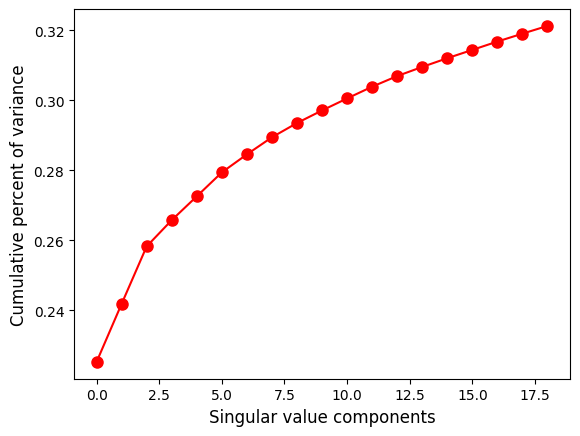

In [65]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [66]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=rated_metadata.title.tolist())

In [67]:
latent_matrix_1_df.shape

(26744, 19)

### Create a User-Item Matrix

In [31]:
from scipy.sparse import csr_matrix

In [33]:
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [42]:
#distinct movieId in ratings number
ratings['movieId'].nunique()

26744

In [43]:
#distinct movie id in movies number
movies['movieId'].nunique()

27278

In [34]:
user_movies_data = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

<ipython-input-34-7aa2d938c371>:1: PerformanceWarning: The following operation may generate 3703856792 cells in the resulting pandas object.
  user_movies_data = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)


In [35]:
user_movies_data

userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,0.0,5.0,0.0,3.0,0.0,0.0,2.0,0.0,3.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Collaborative Filtering

In [41]:
print(user_movies_data.shape)
print(metadata.shape)

(26744, 138493)
(27278, 3)


In [58]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2, index=rated_metadata.title.tolist())

In [59]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),589.735003,107.081311,-115.490219,-38.460889,-77.829787,-173.940404,65.401079,140.544963,172.555116,21.580060,...,11.097479,-15.349793,-5.519123,-5.472716,-6.875128,-0.961897,-11.446314,-9.730218,-8.282935,-3.433124
Jumanji (1995),259.986239,95.735934,-120.136391,74.226530,28.674243,-16.149593,64.032448,49.423658,-18.554235,7.299461,...,-21.314486,1.216169,13.542273,-7.496053,19.278768,-25.102790,-10.633264,5.297693,-13.300229,-6.899806
Grumpier Old Men (1995),111.690215,81.474663,-19.517680,61.706105,15.779738,-6.129166,-5.004223,39.031759,125.850115,25.819374,...,-1.065191,8.016899,-7.072682,5.414287,10.867343,-14.406981,8.466538,-4.592045,3.540341,1.948749
Waiting to Exhale (1995),26.423422,33.325390,1.201866,11.678328,23.260363,-4.053368,-2.165683,7.653293,12.584991,-2.519516,...,-0.780511,3.298834,-2.207643,-3.913092,-0.332848,-4.246057,-0.803639,-0.271722,0.436987,0.821211
Father of the Bride Part II (1995),96.625161,82.859425,-31.663186,56.029408,34.352171,-22.303694,3.715283,42.929388,108.571553,26.274224,...,-7.734643,0.468453,-7.419308,8.935604,6.482320,-7.265628,8.026905,-3.542874,3.184791,0.232193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kein Bund für's Leben (2007),0.028799,-0.039553,-0.032570,0.016500,0.028559,0.002982,0.058873,0.003663,0.031953,-0.045000,...,0.029008,-0.025187,0.001959,-0.007666,0.048097,-0.013303,0.000753,0.028535,-0.020980,0.020020
"Feuer, Eis & Dosenbier (2002)",0.028799,-0.039553,-0.032570,0.016500,0.028559,0.002982,0.058873,0.003663,0.031953,-0.045000,...,0.029008,-0.025187,0.001959,-0.007666,0.048097,-0.013303,0.000753,0.028535,-0.020980,0.020020
The Pirates (2014),0.021406,-0.026201,-0.019735,0.008202,0.014002,0.032517,0.009603,0.001974,0.016157,-0.027717,...,-0.016166,0.008102,0.016303,0.008071,-0.018291,0.005823,-0.002863,-0.002864,-0.000959,-0.012248
Rentun Ruusu (2001),0.023991,-0.032698,-0.019295,-0.008706,0.017380,0.030941,0.018349,0.012458,0.008782,-0.015685,...,0.014199,0.016938,0.009706,-0.017806,-0.002263,-0.011935,0.019990,-0.001359,0.026538,-0.005743


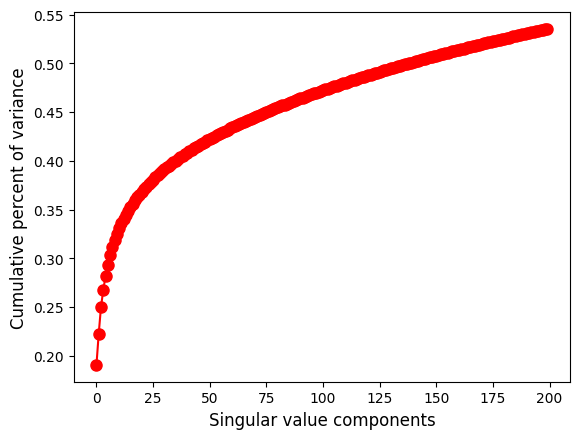

In [60]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid}
# dictDf = {'collaborative': score_2}
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid,
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Bambi Meets Godzilla (1969),0.990567,0.108627,0.549597
"Legend of Sleepy Hollow, The (1949)",0.987076,0.146516,0.566796
Emotion (1966),0.984517,0.052234,0.518376
Shrek 2 (2004),0.982165,0.467514,0.724840
Dr. Horrible's Sing-Along Blog (2008),0.980900,0.265614,0.623257
Benji (1974),0.979785,0.238020,0.608903
Pure Luck (1991),0.979026,0.147272,0.563149
Shark Tale (2004),0.978543,0.288800,0.633671
Dead on Time (1983),0.977675,0.079293,0.528484
Looney Tunes: Back in Action (2003),0.976281,0.212403,0.594342


In [69]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.939202,0.619190,0.779196
Star Wars: Episode IV - A New Hope (1977),0.790000,0.590066,0.690033
Independence Day (a.k.a. ID4) (1996),0.700675,0.586929,0.643802
Star Wars: Episode VI - Return of the Jedi (1983),0.780786,0.569975,0.675381
Mission: Impossible (1996),0.847838,0.563466,0.705652
Aladdin (1992),0.813946,0.563370,0.688658
Back to the Future (1985),0.898523,0.558806,0.728664
Twister (1996),0.878316,0.557101,0.717709
Men in Black (a.k.a. MIB) (1997),0.926652,0.555878,0.741265
"Nutty Professor, The (1996)",0.516830,0.554339,0.535584


In [70]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.939202,0.619190,0.779196
Groundhog Day (1993),0.963779,0.523730,0.743754
Finding Nemo (2003),0.961608,0.521446,0.741527
Men in Black (a.k.a. MIB) (1997),0.926652,0.555878,0.741265
Mars Attacks! (1996),0.952111,0.514531,0.733321
Back to the Future (1985),0.898523,0.558806,0.728664
"Bug's Life, A (1998)",0.902211,0.547760,0.724986
Shrek 2 (2004),0.982165,0.467514,0.724840
"Incredibles, The (2004)",0.941122,0.495063,0.718093
Twister (1996),0.878316,0.557101,0.717709


## Hybrid Recommendation System

In [71]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid}
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [72]:
recommend_similar_movies("Toy Story (1995)")

                                               content  collaborative  \
Toy Story 2 (1999)                            0.939202       0.619190   
Groundhog Day (1993)                          0.963779       0.523730   
Finding Nemo (2003)                           0.961608       0.521446   
Men in Black (a.k.a. MIB) (1997)              0.926652       0.555878   
Mars Attacks! (1996)                          0.952111       0.514531   
Back to the Future (1985)                     0.898523       0.558806   
Bug's Life, A (1998)                          0.902211       0.547760   
Shrek 2 (2004)                                0.982165       0.467514   
Incredibles, The (2004)                       0.941122       0.495063   
Twister (1996)                                0.878316       0.557101   
Austin Powers: The Spy Who Shagged Me (1999)  0.965200       0.447747   

                                                hybrid  
Toy Story 2 (1999)                            0.779196  
Groundhog

In [73]:
recommend_similar_movies("GoldenEye (1995)")

                                    content  collaborative    hybrid
Die Hard: With a Vengeance (1995)  0.854082       0.744025  0.799053
Cliffhanger (1993)                 0.826263       0.752550  0.789406
Tomorrow Never Dies (1997)         0.916129       0.655083  0.785606
Speed (1994)                       0.894178       0.641146  0.767662
Net, The (1995)                    0.865559       0.669649  0.767604
Die Another Day (2002)             0.940950       0.480164  0.710557
Waterworld (1995)                  0.661055       0.758038  0.709546
Rock, The (1996)                   0.894025       0.524262  0.709143
In the Line of Fire (1993)         0.862247       0.545999  0.704123
Seven (a.k.a. Se7en) (1995)        0.883530       0.517533  0.700531
Hackers (1995)                     0.875270       0.525741  0.700506


In [74]:
recommend_similar_movies("Twister (1996)")

                                       content  collaborative    hybrid
Dragonheart (1996)                    0.950916       0.701262  0.826089
Mission: Impossible (1996)            0.866320       0.747258  0.806789
Eraser (1996)                         0.833215       0.760099  0.796657
Speed (1994)                          0.960743       0.614407  0.787575
Rock, The (1996)                      0.888201       0.664361  0.776281
Independence Day (a.k.a. ID4) (1996)  0.746502       0.766282  0.756392
Ransom (1996)                         0.872246       0.613759  0.743002
Net, The (1995)                       0.972552       0.495131  0.733842
Primal Fear (1996)                    0.903482       0.550669  0.727076
Mummy, The (1999)                     0.952798       0.495785  0.724292
Speed 2: Cruise Control (1997)        0.938537       0.504972  0.721755


# Matrix Factorization Recommender

- R – The user-movie rating matrix
- K – Number of latent features
- alpha – Learning rate for stochastic gradient descent
- beta – Regularization parameter for bias
- iterations – Number of iterations to perform stochastic gradient descent

###Utilizing GPU in Handling Large-Scale Sparse Matrices and Matrix Factorization with Stochastic Gradient Descent (SGD)
The code efficiently processes large sparse matrices (with over 3 billion cells) and performs matrix factorizations using algorithms like SGD, leveraging PyTorch's CUDA-accelerated sparse tensor operations for faster computations, particularly during batch updates and predictions in collaborative filtering tasks.

In [44]:
"""
import numpy as np
import torch
import torch.nn as nn
import torch.sparse
import pandas as pd
from torch.utils.data import DataLoader, Dataset

def prepare_data(ratings, min_ratings=5):
    #Prepare and filter the data to avoid memory issues
    # Filter users and items with minimum ratings
    user_counts = ratings['userId'].value_counts()
    movie_counts = ratings['movieId'].value_counts()

    valid_users = user_counts[user_counts >= min_ratings].index
    valid_movies = movie_counts[movie_counts >= min_ratings].index

    filtered_ratings = ratings[ratings['userId'].isin(valid_users) & ratings['movieId'].isin(valid_movies)]

    # Create pivot table with filtered data
    user_mapping = {user: idx for idx, user in enumerate(valid_users)}
    movie_mapping = {movie: idx for idx, movie in enumerate(valid_movies)}

    filtered_ratings['userId'] = filtered_ratings['userId'].map(user_mapping)
    filtered_ratings['movieId'] = filtered_ratings['movieId'].map(movie_mapping)

    # Create sparse matrix representation
    row = torch.LongTensor(filtered_ratings['userId'].values)
    col = torch.LongTensor(filtered_ratings['movieId'].values)
    data = torch.FloatTensor(filtered_ratings['rating'].values)
    R_sparse = torch.sparse.FloatTensor(torch.stack([row, col]), data, torch.Size([len(valid_users), len(valid_movies)]))

    return R_sparse, len(valid_users), len(valid_movies)

class MF():
    def __init__(self, R_sparse, num_users, num_items, K, alpha, beta, iterations, batch_size=2048):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.R_sparse = R_sparse.to(self.device)
        self.num_users = num_users
        self.num_items = num_items
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.batch_size = batch_size

        # Initialize matrices
        self.P = torch.normal(mean=0., std=1./self.K, size=(self.num_users, self.K)).to(self.device)
        self.Q = torch.normal(mean=0., std=1./self.K, size=(self.num_items, self.K)).to(self.device)

        self.b_u = torch.zeros(self.num_users).to(self.device)
        self.b_i = torch.zeros(self.num_items).to(self.device)
        self.b = torch.sum(self.R_sparse.values()) / self.R_sparse.values().numel()

    def sgd(self):
        #Optimized stochastic gradient descent using batches
        rows, cols = self.R_sparse.indices()
        ratings = self.R_sparse.values()

        # Shuffle indices
        perm = torch.randperm(len(ratings))
        rows, cols, ratings = rows[perm], cols[perm], ratings[perm]

        for i in range(0, len(ratings), self.batch_size):
            batch_rows = rows[i:i+self.batch_size]
            batch_cols = cols[i:i+self.batch_size]
            batch_ratings = ratings[i:i+self.batch_size]

            # Calculate predictions for the batch
            pred = self.get_batch_predictions(batch_rows, batch_cols)

            # Compute errors and gradients
            errors = batch_ratings - pred
            self.update_parameters(batch_rows, batch_cols, errors)

    def get_batch_predictions(self, batch_rows, batch_cols):
        #Get predictions for a batch of samples
        pred = self.b + self.b_u[batch_rows] + self.b_i[batch_cols] + torch.sum(self.P[batch_rows] * self.Q[batch_cols], dim=1)
        return pred

    def update_parameters(self, batch_rows, batch_cols, errors):
        #Update P, Q, b_u, and b_i based on errors
        self.b_u[batch_rows] += self.alpha * (errors - self.beta * self.b_u[batch_rows])
        self.b_i[batch_cols] += self.alpha * (errors - self.beta * self.b_i[batch_cols])

        # Update P and Q matrices
        self.P[batch_rows] += self.alpha * (errors.unsqueeze(1) * self.Q[batch_cols] - self.beta * self.P[batch_rows])
        self.Q[batch_cols] += self.alpha * (errors.unsqueeze(1) * self.P[batch_rows] - self.beta * self.Q[batch_cols])

    def mse(self):
        #Compute mean squared error for full matrix
        mask = self.R_sparse.values() != 0
        pred = self.full_matrix()
        error = torch.pow(self.R_sparse.values()[mask] - pred[mask], 2).sum()
        return torch.sqrt(error).item()

    def full_matrix(self):
        #Compute the full predicted matrix
        return self.b + self.b_u.unsqueeze(1) + self.b_i.unsqueeze(0) + torch.mm(self.P, self.Q.t())

    def train(self):
        for i in range(self.iterations):
            self.sgd()
            mse = self.mse()
            if (i + 1) % 20 == 0:
                print(f"Iteration {i+1}; error = {mse:.4f}")

# Usage
def train_model(ratings):
    # Prepare and filter data
    R_sparse, num_users, num_items = prepare_data(ratings, min_ratings=5)

    # Train model
    mf = MF(R_sparse, num_users, num_items, K=10, alpha=0.001, beta=0.01, iterations=50)
    mf.train()

    # Get predictions
    print("\nP x Q:")
    predictions = mf.full_matrix().cpu().numpy()
    print(predictions)

    return mf


mf = train_model(ratings)

"""

### on using 20m ratings data set the ratingss df leads up to 3 billion + matrix operations which takes forever to run, thats why for this case taking 1 m data set

In [7]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip

--2024-11-15 07:13:50--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  27.4MB/s    in 0.2s    

2024-11-15 07:13:50 (27.4 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [8]:
! unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [10]:
#read ratings.dat file and store data set as df named rating ok
rating = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['userId', 'movieId', 'rating', 'timestamp'])
rating

<ipython-input-10-401c755b670b>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rating = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['userId', 'movieId', 'rating', 'timestamp'])


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [11]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [12]:
R= np.array(rating.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [13]:
R

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [14]:
mf = MF(R, K=10, alpha=0.001, beta=0.01, iterations=50)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 900.0328
Iteration: 40 ; error = 882.0265

P x Q:
[[4.48875487 3.37217321 3.21851161 ... 3.9097805  4.18296297 3.96544612]
 [3.97672515 3.21669592 3.08726303 ... 3.51550821 3.76842042 3.73292843]
 [4.33530781 3.35263643 3.20119801 ... 3.77896841 4.07520682 3.93749394]
 ...
 [4.12002788 3.1016656  2.95103764 ... 3.54874401 3.83545002 3.70653888]
 [4.10438532 2.98279475 2.92060118 ... 3.59131322 3.77133769 3.68906038]
 [3.82409454 2.78041201 2.61493407 ... 3.3223115  3.60314292 3.4517845 ]]



## Surprise

In [15]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [16]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [30]:
rated_metadata

,movieId,title,full_metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),nan
27274,131256,"Feuer, Eis & Dosenbier (2002)",nan
27275,131258,The Pirates (2014),bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),nan


In [31]:
Mapping_file = dict(zip(rated_metadata.title.tolist(), rated_metadata.movieId.tolist()))

In [32]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.7888


0.7888365419827437

In [41]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}
        predictedL = []
        for i, j in d.items():
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3]))
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)
        pdf.set_index('movies', inplace=True)
        return pdf.head(10)
    else:
        print("User Id does not exist in the list!")
        return None

In [42]:
userId = 1
pred_user_rating(userId)

,ratings
movies,
"Avengers, The (2012)",4.548270
Star Trek (2009),4.532144
Serenity (2005),4.523963
"Dark Knight Rises, The (2012)",4.511224
Sherlock Holmes: A Game of Shadows (2011),4.493430
Star Trek Into Darkness (2013),4.424178
"Batman: The Dark Knight Returns, Part 2 (2013)",4.422041
Shadows of Our Forgotten Ancestors (Tini zabutykh predkiv) (1964),4.414919
Iron Man (2008),4.414808


In [43]:
pred_user_rating(420)

,ratings
movies,
Life Is Beautiful (La Vita è bella) (1997),4.810842
Mr. Holland's Opus (1995),4.628060
"Shawshank Redemption, The (1994)",4.565372
Presto (2008),4.468453
Louis C.K.: Oh My God (2013),4.449249
"Lord of the Rings: The Return of the King, The (2003)",4.447045
Schindler's List (1993),4.443586
"Blind Side, The (2009)",4.425455
"Lord of the Rings: The Fellowship of the Ring, The (2001)",4.406154
